In [1]:
from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
from credit.xr_sampler import XRSamplerByYear
import yaml
import multiprocessing
from functools import partial


# preprocess

In [2]:
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train"
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/forecast"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/archive_skebs/skebs_conv_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_12_24h/forecast"


In [3]:
eval_fh = 6
error_files = glob(join(rollout_dir, f"2012*/pred*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"2013*/pred*{eval_fh:03}.nc"))
print(error_files[:2])

['/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/forecast/2012-11-20T00Z/pred_2012-11-20T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/forecast/2012-07-31T00Z/pred_2012-07-31T00Z_006.nc']


In [15]:
with open("/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained/model.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

sampler = XRSamplerByYear("/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained/model.yml")

def get_data(rollout_files):
    # get pred and true data
    pred_da_list = []
    true_da_list = []
    for file in rollout_files:
        ds = xr.open_dataset(file)
        pred_da_list.append(ds)
        
        da_true = sampler(ds.time.values[0])
        true_da_list.append(da_true)
    
    da_pred = xr.concat(pred_da_list, dim='time')
    da_true = xr.concat(true_da_list, dim='time')
    da_true = da_true.assign_coords(level=da_pred.level)
    return da_true, da_pred

In [5]:
def error(eval_fh):
    rollout_files = glob(join(rollout_dir, f"2012*/pred*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"2013*/pred*{eval_fh:03}.nc"))
    obs, pred = get_data(rollout_files)
    error = np.sqrt((pred - obs) ** 2)
    return error.mean(dim=["time", "longitude"])

In [6]:
# f = partial(rmse, )
forecast_hours = list(range(6, 360 + 1, 6))
# forecast_hours = list(range(6, 13, 6))
with multiprocessing.Pool(12) as p:
    result = p.map(error, forecast_hours)

In [7]:
fh_index = xr.DataArray(
    np.array(forecast_hours), dims="fh"
)
combined = xr.concat(result, dim=fh_index)

In [8]:
combined

<xarray.Dataset> Size: 7MB
Dimensions:   (fh: 60, level: 32, latitude: 192, ilev: 33)
Coordinates:
  * level     (level) int64 256B 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * latitude  (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * ilev      (ilev) float32 132B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * fh        (fh) int64 480B 6 12 18 24 30 36 42 ... 330 336 342 348 354 360
Data variables: (12/21)
    U         (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    V         (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    T         (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    Qtot      (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    PS        (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    TREFHT    (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    ...        ...
    FSNS      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    FLNS      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    FSNT      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    FLNT      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    SHFLX     (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    LHFLX     (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>

In [9]:
combined.to_netcdf(join(rollout_dir, "rmse_lat_lev_unwted_2012-06-05_15dayforecast_16dayinterval.nc"))

# compute magnitudes

In [16]:
def zonal_averaged_magnitudes(eval_fh):
    rollout_files = glob(join(rollout_dir, f"2012*/pred*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"2013*/pred*{eval_fh:03}.nc"))
    obs, pred = get_data(rollout_files)
    error = np.abs(pred - obs)
    return error.mean(dim=["time", "longitude"])

In [17]:
# f = partial(rmse, )
forecast_hours = list(range(6, 360 + 1, 6))
# forecast_hours = list(range(6, 13, 6))
with multiprocessing.Pool(12) as p:
    result = p.map(zonal_averaged_magnitudes, forecast_hours)
fh_index = xr.DataArray(
    np.array(forecast_hours), dims="fh"
)
combined = xr.concat(result, dim=fh_index)

In [18]:
combined.to_netcdf(join(rollout_dir, "magnitudes_lat_lev_unwted_2012-06-05_15dayforecast_16dayinterval.nc"))

In [19]:
combined

<xarray.Dataset> Size: 7MB
Dimensions:   (fh: 60, level: 32, latitude: 192, ilev: 33)
Coordinates:
  * level     (level) int64 256B 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * latitude  (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * ilev      (ilev) float32 132B 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * fh        (fh) int64 480B 6 12 18 24 30 36 42 ... 330 336 342 348 354 360
Data variables: (12/21)
    U         (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    V         (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    T         (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    Qtot      (fh, level, latitude) float32 1MB dask.array<chunksize=(1, 32, 192), meta=np.ndarray>
    PS        (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    TREFHT    (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    ...        ...
    FSNS      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    FLNS      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    FSNT      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    FLNT      (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    SHFLX     (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>
    LHFLX     (fh, latitude) float32 46kB dask.array<chunksize=(1, 192), meta=np.ndarray>

In [20]:
combined.mean(dim="fh").to_netcdf(join(rollout_dir, "magnitudes_fhmean_lat_lev_unwted_2012-06-05_15dayforecast_16dayinterval.nc"))

# visualize RMSE

In [16]:
berner_levels = np.concatenate([np.linspace(0, 10, 14), 
                                np.linspace(10, 20, 7),
                               np.linspace(20, 30, 3),
                               np.linspace(30, 40, 8)], axis=0)
std_berner = std.assign_coords(level=berner_levels)


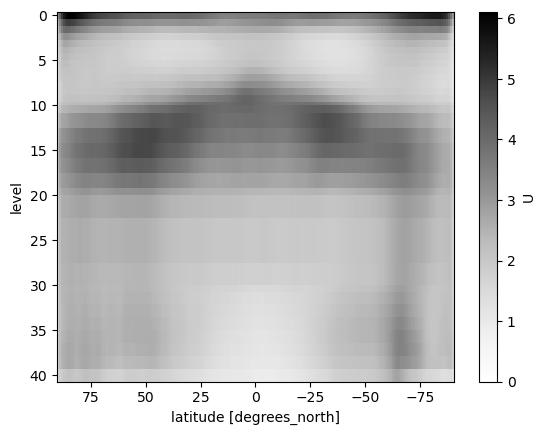

In [17]:
std_berner.U.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

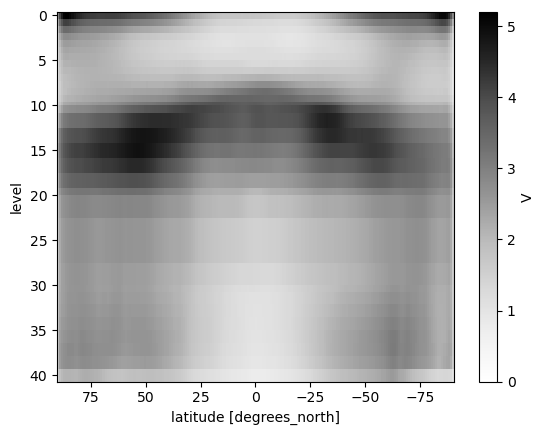

In [18]:
std_berner.V.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

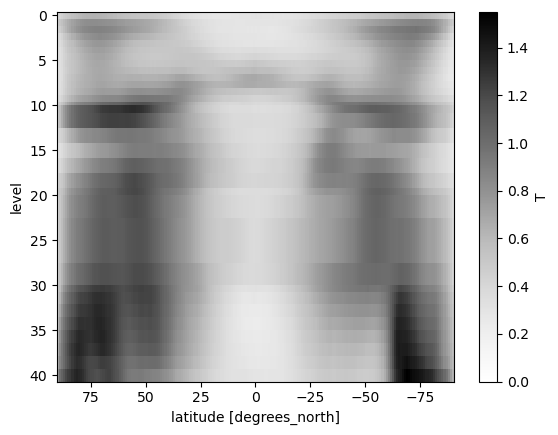

In [19]:
std_berner.T.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

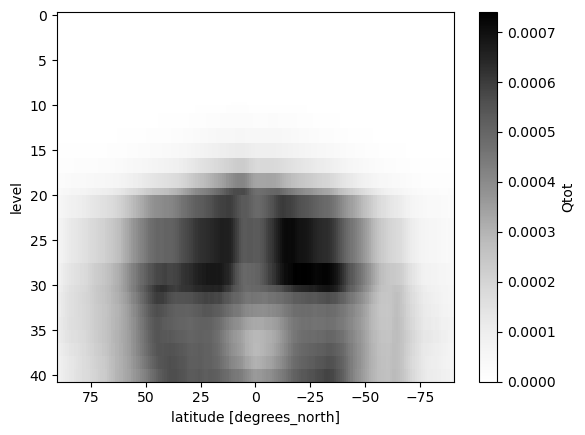

In [20]:
std_berner.Qtot.plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

np.log(mean["U"]).plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

np.log(mean["V"]).plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

mean["T"].plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

mean["Qtot"].plot(yincrease=False, xincrease=False, cmap="Greys", vmin=0)

## save files

In [21]:
save_path = join(rollout_dir, "spread_error_maps")
os.makedirs(save_path, exist_ok=True)
for fh, res in zip(forecast_hours, result):
    res[0].to_netcdf(join(save_path, f"rmse_{fh:03}.nc"))
    res[1].to_netcdf(join(save_path, f"std_{fh:03}.nc"))
